<h1 align="center">Machine Learning</h1><h2 align="center" style="margin:10px">Assignment 4</h2>

In [92]:
# Student names and numbers:
# David Le - 280071
# Florin-Leonard Bordei
# Jaume Lopez Topping

The assignments below should be solved and documented as a mini-project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to. The easiest way to convert to pdf is to save this notebook as .html (File-->Download as-->HTML) and then convert this html file to pdf. You can also export as pdf directly, but here you need to watch your margins as the converter will cut off your code (i.e. make vertical code!).

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

In [187]:
# Import all necessary libraries here
import pandas as pd
import numpy as np
import graphviz
import sklearn
import statistics
import matplotlib.pyplot as plt
import seaborn as sn
import random
import pydotplus
import mglearn

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from IPython.display import display
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

# Exercise 1: Preprocessing and Data Exploration

This assignment will depart from the infamous California housing data. This is a dataset obtained from the StatLib repository. Here is the included description:

"We collected information on the variables using all the block groups in California from the 1990 Cens us.
In this sample a block group on average includes 1425.5 individuals living in a geographically compact
area. Naturally, the geographical area included varies inversely with the population density. We computed
distances among the centroids of each block group as measured in latitude and longitude. We excluded
all the block groups reporting zero entries for the independent and dependent variables. The final data
contained 20,640 observations on 9 variables. The dependent variable is ln(median house value)."

In [188]:
from sklearn.datasets.california_housing import fetch_california_housing 
# Note: Since the California Housing dataset will be removed from sklearn,
# it is included in the project-zip-folder. But for now, you should be able to
# fetch the data as:
houses = fetch_california_housing()
print(houses.DESCR);

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

**a)** In the description, the median house value is stated as the dependent variable. We want to treat it as
   a classification problem. Therefore, you must create a new dependent variable with column header 'classifier'.
   The new variable must be boolean where one value (e.g. 0) is used to denote entries whose median house value is
   less than or equal to the median of the median_house_value column and the other (e.g. 1) is used to denote entries whose
   median house value is greater than the median of the median_house_value column.

In [189]:
# Introducing classifier and converting to classification problem
median = statistics.median(houses.target)
new_target_name = 'classifier'
new_target = houses.target <= median

data = []
for idx, row in enumerate(houses.data):
    data.append(np.append(row, new_target[idx]))
      
houses.feature_names.append('Classifier')

# Illustration purpose
df = pd.DataFrame(data, columns=houses.feature_names)
df.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Classifier  
0    -122.23         0.0  
1    -122.22         0.0  
2    -122.24         0.0  
3    -122.25         0.0  
4    -122.25         0.0

**b)** Identify potential outliers and substantiate using Boxplots. Discuss what approach you want to take for handling
   outliers and implement this approach. (note: be careful about any categorial variables!)

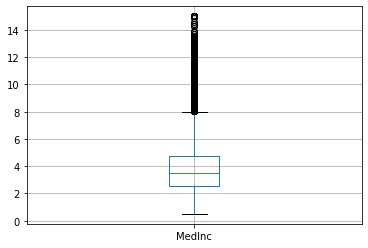

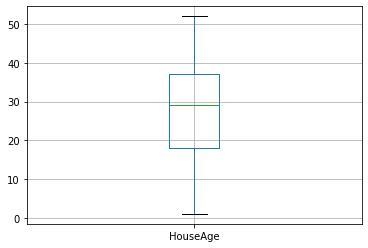

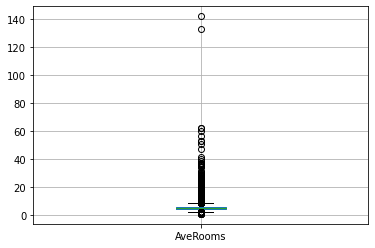

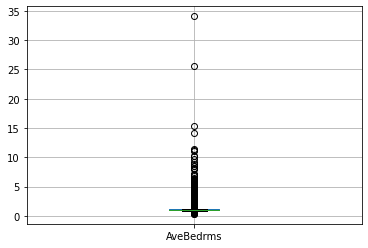

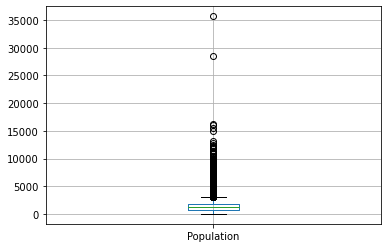

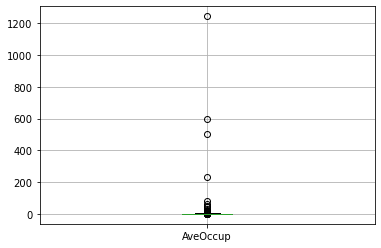

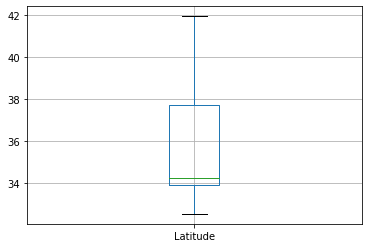

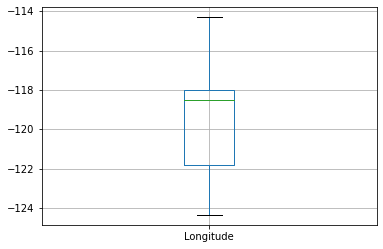

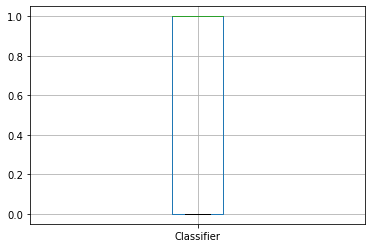

In [190]:
# No categorical vars except Classifier which we are gonna ignore

# Plotting BoxPlot for all columns
for column in df:
    plt.figure()
    df.boxplot([column])

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'Classifier'}>]], dtype=object)

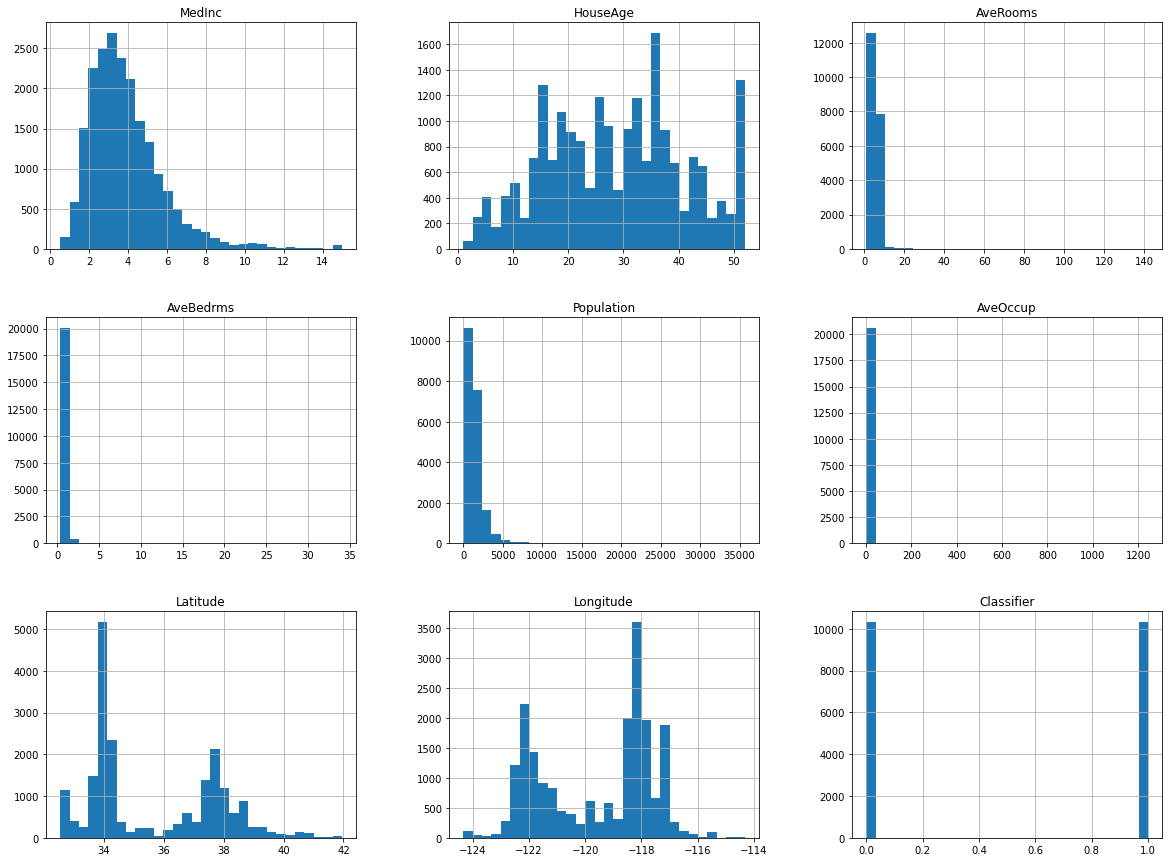

In [191]:
# Visualization with histograms
df.hist(bins=30, figsize=(20,15))

In [192]:
# Data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers -> trim
# From above boxplots and histograms, outliers appear in MedInc, AveRooms, AveBedrms, Population, AveOccup
df_filtered = df
for column in df_filtered[['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]:
    Q1 = df_filtered[column].quantile(0.25)
    Q3 = df_filtered[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # We want to get rid of outliers above maximum
    max = Q3+1.5*IQR
    min = Q1-1.5*IQR
    
    max_data = df_filtered[df_filtered[column] <= max]
    max_outliers = len(df_filtered[column]) - len(max_data[column])
    print("Number of outliers for {} above maximum: {}".format(column, max_outliers))
    df_filtered = max_data
    
    min_data = df_filtered[df_filtered[column] >= min]
    min_outliers = len(df_filtered[column]) - len(min_data[column])
    print("Number of outliers for {} below minimum: {}".format(column, min_outliers))
    df_filtered = min_data
    
    df_filtered = df_filtered.reset_index(drop=True)
df_filtered

# Quite a lot of outliers, we will keep them and analyse further down with and without the outliers to see, if there is anything
# interesting.

Number of outliers for MedInc above maximum: 681
Number of outliers for MedInc below minimum: 0
Number of outliers for AveRooms above maximum: 384
Number of outliers for AveRooms below minimum: 55
Number of outliers for AveBedrms above maximum: 938
Number of outliers for AveBedrms below minimum: 178
Number of outliers for Population above maximum: 1063
Number of outliers for Population below minimum: 0
Number of outliers for AveOccup above maximum: 526
Number of outliers for AveOccup below minimum: 2


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
1      3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   
2      4.0368      52.0  4.761658   1.103627       413.0  2.139896     37.85   
3      3.6591      52.0  4.931907   0.951362      1094.0  2.128405     37.84   
4      3.1200      52.0  4.797527   1.061824      1157.0  1.788253     37.84   
...       ...       ...       ...        ...         ...       ...       ...   
16808  3.7125      28.0  6.779070   1.148256      1041.0  3.026163     39.27   
16809  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
16810  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
16811  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
16812  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  Classifier  
0        -122.25         0.0  
1        -122.25         0.0  
2        -122.25         0.0  
3        -122.25         0.0  
4        -122.25         0.0  
...          ...         ...  
16808    -121.56         1.0  
16809    -121.09         1.0  
16810    -121.22         1.0  
16811    -121.32         1.0  
16812    -121.24         1.0  

[16813 rows x 9 columns]

array([[<AxesSubplot:title={'center':'MedInc'}>,
        <AxesSubplot:title={'center':'HouseAge'}>,
        <AxesSubplot:title={'center':'AveRooms'}>],
       [<AxesSubplot:title={'center':'AveBedrms'}>,
        <AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'AveOccup'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>,
        <AxesSubplot:title={'center':'Classifier'}>]], dtype=object)

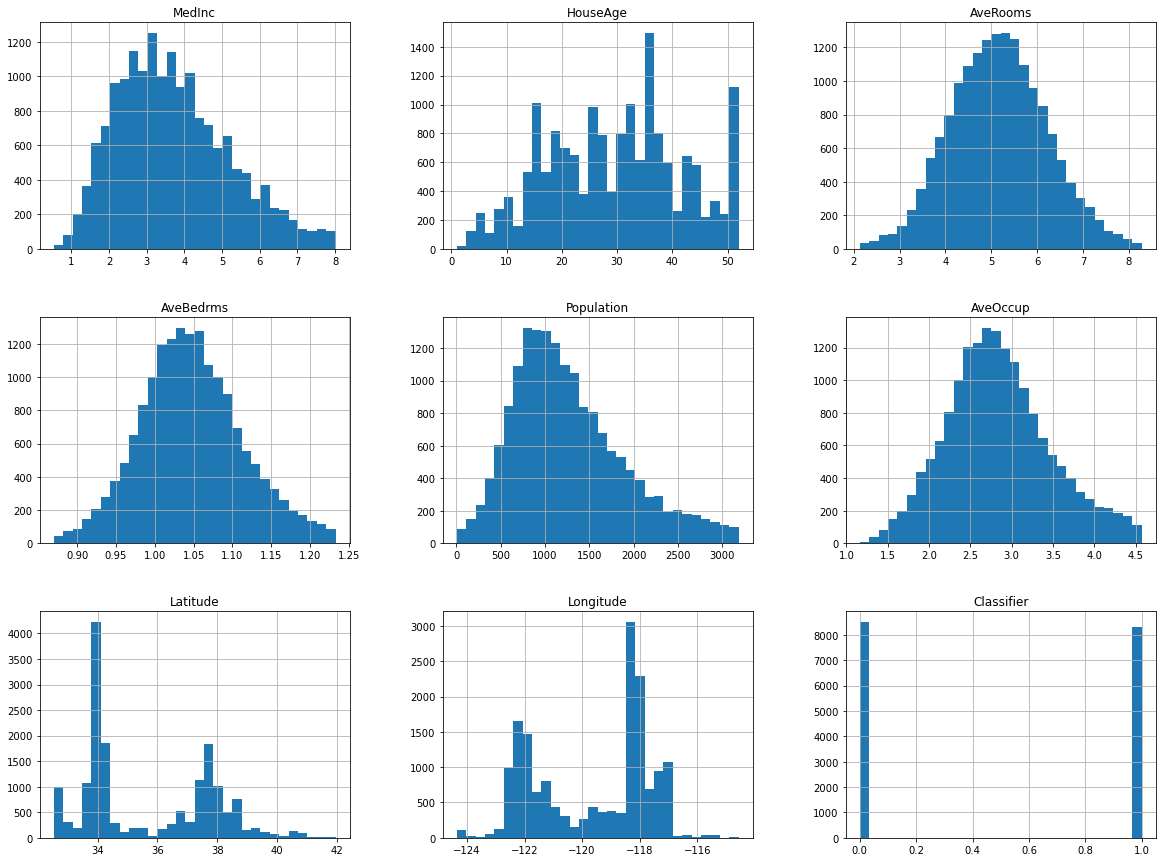

In [193]:
# Visualization with histograms
df_filtered.hist(bins=30, figsize=(20,15))

# With further analysis, dataset seems to be okay.

**c)** Create a correlation matrix and make scatterplots of all pairs of the variables. Comment on any interesting correlations (or lack of correlations).

There is one thing we should notice, as we asked question whether median house value is less than or equal to the media of the median_house_value column, the correlation would have the opposite signs for all the features for the original feature median_house_value (with these results, it is a bit unintuitive)
From what we can see, the median_house_value positively correlates with median income (makes send, who earns more, can afford more) and same applies to the second place: average of room, which psoitively correlates.
Negative correlation is with latitude and longitude, and looking on the map of California: both are negative, that means the direction is: southeast -> probably cost and beaches will have higher mean (from west, there is Pacific ocean.) - so we should definitely include latitude and longitude as one of the impacting features.

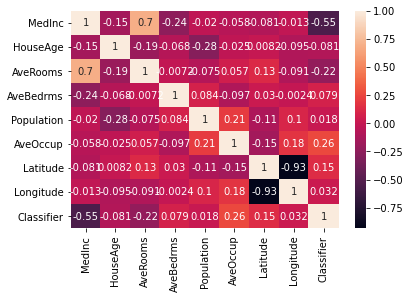

Classifier    1.000000
AveOccup      0.264597
Latitude      0.146030
AveBedrms     0.078718
Longitude     0.032066
Population    0.017926
HouseAge     -0.080788
AveRooms     -0.220720
MedInc       -0.547904
Name: Classifier, dtype: float64

In [194]:
corr_matrix_filtered = df_filtered.corr()
sn.heatmap(corr_matrix_filtered, annot=True)
plt.show()

corr_matrix_filtered['Classifier'].sort_values(ascending=False)

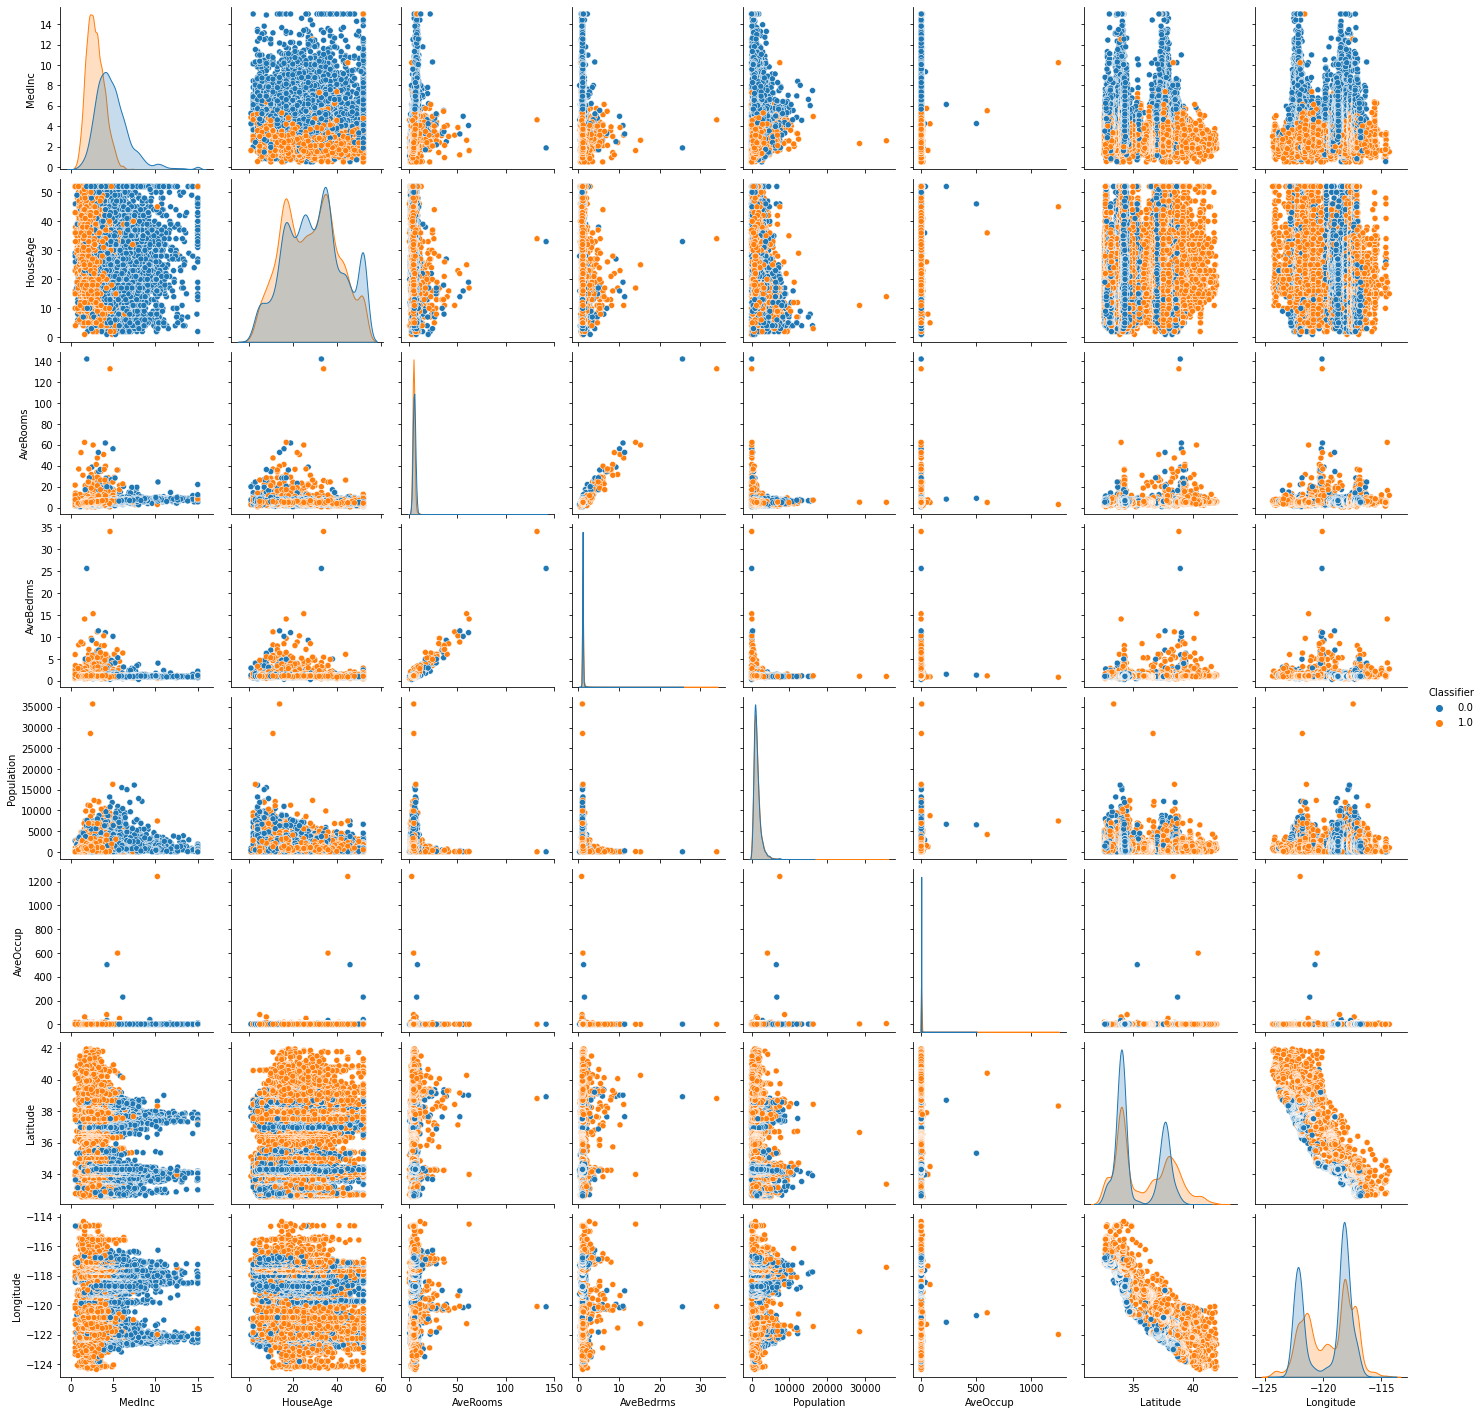

In [101]:
sn.pairplot(df, hue = 'Classifier')

**d)** Create a training set and a test set.

In [195]:
# Filtered dataset
classifier = df_filtered.pop('Classifier')
# trainval = train + validation set, as later on we wanna split it to training + validation set
X_trainval, X_test, y_trainval, y_test = train_test_split(df_filtered, classifier, random_state=0)
print("X_trainval shape: {}".format(X_trainval.shape))
print("X_test shape: {}".format(X_test.shape))

X_trainval shape: (12609, 8)
X_test shape: (4204, 8)


**e)** Get the data ready for training by performing relevant scaling and other preprocessing steps you find necessary.

As seen above, there is no categorical variables, all features are numerical
Since it is binary classification (0 and 1), we can define types of errors: False Positive and False Negative. Are they of any importance for our research? We considered not to be.

Let's check if the dataset is balanced after filtering the outliers:

In [196]:
ones = np.count_nonzero(classifier)
print("1: {}".format(ones))
zeros = classifier.size - ones
print("0: {}".format(zeros))

# Looks all right

print(df_filtered.isnull().sum())
# All good -> no need to call dropna() to remove Nan/empty

#At this point, we want to standardize the features to have the same scale -> StandardScaler - which will
# bring all the features to the samee magnitude 
# RobustScaler - no need, since we got rid of outliers (Or we could have outliers included and use RobusScaler)
# We chose StandardScaler since it is indrustry go to algorithm.

standard_scaler = StandardScaler()
standard_scaler.fit(X_trainval)
X_trainval_scaled = standard_scaler.transform(X_trainval)
X_test_scaled = standard_scaler.transform(X_test)

1: 8306
0: 8507
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


# Exercise 2: Decision Trees

**a)** Using the training data, divide this into a training and validation set using the same ratio as in (1e).

In [197]:
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval_scaled, y_trainval, random_state=1)
print(X_train.shape)
print(X_valid.shape)

(9456, 8)
(3153, 8)


**b)** Learn a decision tree using the training data and evaluate its performance on both the training data
   and the validation data. Use the default values of the hyperparameters. Comment on the accuracy of both.
   What does this tell you about overfitting?

In [198]:
tree = DecisionTreeClassifier(random_state=2)
tree.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on valid set: {:.3f}".format(tree.score(X_valid, y_valid)))

# It created a complex model, which fits well on training data set (100% which also tells us about existence of pure leaves),
# but does not generalize well on new data set (83%) ->
# overfitting (which is well known for deciosion tree based models)

Accuracy on training set: 1.000
Accuracy on valid set: 0.831


**c)** Using the training data, generate random training/validation partitions of varying sizes and analyze how the accuracy results vary (consult the
   documentation for train_test_split(.)).

In [199]:
best_score = 0
best_training_size = 0

# Checking if there is any imbalance
print(y_train.size)
print(np.count_nonzero(y_train))


for i in range(10):
    x = float("{:.2f}".format(random.uniform(0.4, 0.9)))
    X_train_rand, X_valid_rand, y_train_rand, y_valid_rand = train_test_split(X_train, y_train, random_state=3, train_size=x)
    tree_rand = DecisionTreeClassifier(random_state=4)
    tree_rand.fit(X_train_rand, y_train_rand)
    valid_score = tree_rand.score(X_valid_rand, y_valid_rand)
    print("Accuracy on training set with {} train size: {:.3f}".format(x, tree_rand.score(X_train_rand, y_train_rand)))
    print("Accuracy on valid set with {}: {:.3f}".format(x, valid_score))
    
    if valid_score > best_score:
        best_score = valid_score
        best_training_size = x
        
print("Best score: {} with training size of {}".format(best_score, best_training_size))
# We can see that the more data it uses for training, the better it gets on generalizing (also, it overfits in all the cases)
# We got ~86% acc with 90/10 train/valid partitions

9456
4628
Accuracy on training set with 0.64 train size: 1.000
Accuracy on valid set with 0.64: 0.835
Accuracy on training set with 0.57 train size: 1.000
Accuracy on valid set with 0.57: 0.835
Accuracy on training set with 0.6 train size: 1.000
Accuracy on valid set with 0.6: 0.838
Accuracy on training set with 0.47 train size: 1.000
Accuracy on valid set with 0.47: 0.823
Accuracy on training set with 0.86 train size: 1.000
Accuracy on valid set with 0.86: 0.839
Accuracy on training set with 0.87 train size: 1.000
Accuracy on valid set with 0.87: 0.848
Accuracy on training set with 0.75 train size: 1.000
Accuracy on valid set with 0.75: 0.840
Accuracy on training set with 0.49 train size: 1.000
Accuracy on valid set with 0.49: 0.833
Accuracy on training set with 0.5 train size: 1.000
Accuracy on valid set with 0.5: 0.826
Accuracy on training set with 0.61 train size: 1.000
Accuracy on valid set with 0.61: 0.838
Best score: 0.8479674796747968 with training size of 0.87


**d)** Display one of the decision trees learned using the training data.

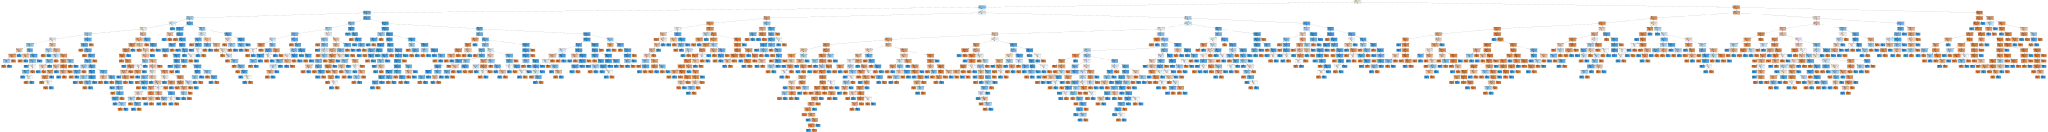

In [134]:
houses.feature_names.pop()
export_graphviz(tree, out_file="tree.dot", class_names=["0", "1"],feature_names=houses.feature_names, impurity=False, filled=True)
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


**e)** What are the most important features as determined by the learned tree and how do the features
   deemed *most important* by the decision tree learner match the generated tree and your understanding of the domain?

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


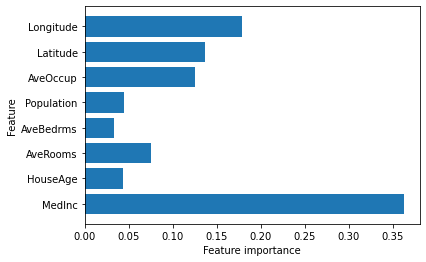

In [135]:
print(houses.feature_names)
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), houses.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances(tree)

Media income, longitude, latitude, average occupancy
MedInc was obvious to be important, alongisde with longitude and latitude, though average rooms that we expected to be highly correlated with house_med_value it not deemed to be high by the tree decision.
Our explanation about having higher median values around costs is further approved (there are also some big cities - LA, SF, San Diego, which also explains the importance of location)

**f)** Try to manually control the complexity of the learned decision tree by adjusting the parameters max_depth,
   min_samples_split, min_samples_leaf, and investigate the effect when changing these parameters by:
   - Visualizing (some of) the trees
   - Evaluating the performance of the models on both the training data and the test data.

Score: 0.8503805899143673 with 10 max_depth
Score: 0.8422930542340628 with 3 min_samples_split
Score: 0.8525214081826832 with 10 mn_samples_leaft


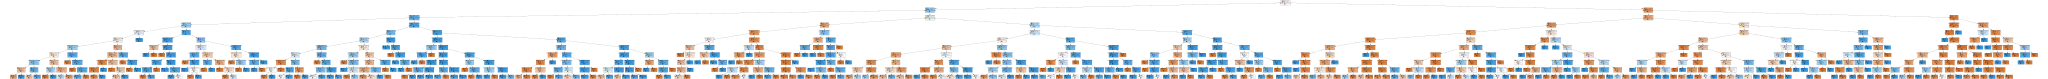

In [136]:
tree_adjusted = DecisionTreeClassifier(max_depth=10, random_state=5)
tree_adjusted.fit(X_train, y_train)
# Using scaled test data, because testing and valid data are already scaled
score = tree_adjusted.score(X_test_scaled, y_test)
print("Score: {} with 10 max_depth".format(score))  

# Pre-pruning definitely helps us wih getting better generalization performance
tree_adjusted2 = DecisionTreeClassifier(min_samples_split=20, random_state=5)
tree_adjusted2.fit(X_train, y_train)
# Using scaled test data, because testing and valid data are already scaled
score = tree_adjusted2.score(X_test_scaled, y_test)
print("Score: {} with 3 min_samples_split".format(score))  

tree_adjusted3 = DecisionTreeClassifier(min_samples_leaf=10, random_state=5)
tree_adjusted3.fit(X_train, y_train)
# Using scaled test data, because testing and valid data are already scaled
score = tree_adjusted3.score(X_test_scaled, y_test)
print("Score: {} with 10 mn_samples_leaft".format(score))  

export_graphviz(tree_adjusted, out_file="tree_adjusted.dot", class_names=["0", "1"],feature_names=houses.feature_names, impurity=False, filled=True)
with open("tree_adjusted.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

**g)** Using the training/validation set, use (for) loops to find the best values of at least two hyperparameters.

In [137]:
best_score = 0
best_parameter = 0

a_list = list(range(1, 15))
for max_depth in a_list:
    tree_adjusted = DecisionTreeClassifier(max_depth=max_depth, random_state=5)
    tree_adjusted.fit(X_train, y_train)
    score = tree_adjusted.score(X_valid, y_valid)
    
    if score > best_score:
        best_score = score
        best_parameter = max_depth

print("Best score: {} with max_depth of {}".format(best_score, best_parameter))        

best_score = 0
best_parameter = 0

b_list = list(range(2, 20))        
for min_samples_split in b_list:
    tree_adjusted = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=6)
    tree_adjusted.fit(X_train, y_train)
    score = tree_adjusted.score(X_valid, y_valid)
    
    if score > best_score:
        best_score = score
        best_parameter = min_samples_split    
        
print("Best score: {} with min_samples_leaf of {}".format(best_score, best_parameter))


Best score: 0.8518870916587377 with max_depth of 10
Best score: 0.8398350777037742 with min_samples_leaf of 14


**h)** Using cross validation, use (for) loops to find the best values of at least two hyperparameters.

In [153]:
# I would prefer here using two for loop in another loop 
# and combine both hyperparameters to search for best combination of hyperparameters, but I will leave here also single for
# loops if that is what you meant

best_score = 0
best_parameter = 0

a_list = list(range(1, 15))
for max_depth in a_list:
    tree_adjusted = DecisionTreeClassifier(max_depth=max_depth, random_state=7)
    tree_adjusted.fit(X_train, y_train)
    kfold = KFold(n_splits=10, shuffle=True, random_state=8)
    scores = cross_val_score(tree_adjusted, X_train, y_train, cv=kfold)
    score = scores.mean()
    
    if score > best_score:
        best_score = score
        best_parameter = max_depth    

print("Best score: {} with max_depth of {}".format(best_score, best_parameter))  
#85% with 10 max_depth
        
best_score = 0
best_parameter = 0

b_list = list(range(2, 10))        
for min_samples_split in b_list:
    tree_adjusted = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=9)
    tree_adjusted.fit(X_train, y_train)
    kfold = KFold(n_splits=10, shuffle=True, random_state=10)
    scores = cross_val_score(tree_adjusted, X_train, y_train, cv=kfold)
    score = scores.mean()
    
    if score > best_score:
        best_score = score
        best_parameter = min_samples_split            
        
print("Best score: {} with min_samples_split of {}".format(best_score, best_parameter)) 
# 84% with min_samples_split of 9
      
best_score = 0
best_max_depth = 0
best_min_samples_split = 0
    
for max_depth in a_list:
    for min_samples_split in b_list:
        tree_adjusted = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=9)
        tree_adjusted.fit(X_train, y_train)
        kfold = KFold(n_splits=10, shuffle=True, random_state=10)
        scores = cross_val_score(tree_adjusted, X_train, y_train, cv=kfold)
        score = scores.mean()
    
        if score > best_score:
            best_score = score
            best_max_depth = max_depth
            best_min_samples_split = min_samples_split

print("Best score: {} with max_depth of {} and min_samples_split of {}".format(best_score, best_max_depth, best_min_samples_split))             

Best score: 0.8461270512433302 with max_depth of 8
Best score: 0.8347106726176493 with min_samples_split of 9
Best score: 0.844441312348289 with max_depth of 10 and min_samples_split of 5


**i)** Use an automated process for finding the optimal hyperparameters. (Ask if you are unsure as to what "automated" means in this context).

**j)** Using the "best" of all the above DT models, build a classifier which will be used later.

In [155]:
# Although I would prefer using Random Forest/Gradient Boosted trees, but I guess by refering to DT model you mean specifically
# single Decision tree with tuned hyperparameters
tree_final = DecisionTreeClassifier(max_depth=10, min_samples_split=9, random_state=10)
tree_final.fit(X_train, y_train)
print(tree_final.score(X_train, y_train))
print(tree_final.score(X_test_scaled, y_test))
print(X_train.shape)
print(y_train.shape)

0.9212140439932318
0.8510941960038059
(9456, 8)
(9456,)


# Exercise 3: K-Nearest Neighbor

**a)** Use the data training/validation set obtained in (2a).

In [107]:
print(X_train.shape)
print(X_valid.shape)

(9456, 8)
(3153, 8)


**b)** Classify the instances in the validation set using default settings for the k-NN classifier.

In [116]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy on valid set: {:.3f}".format(knn.score(X_valid, y_valid)))

# Again overfitting

Accuracy on training set: 0.888
Accuracy on valid set: 0.822


**c)** Try experimenting with different values for 'k'. How do the values affect the classification results?
    Feel free to automate this process using the methods explored in the previous exercise.

In [117]:
best_score = 0
best_parameter = 0

c_list = list(range(1, 15))        
for k in c_list:
    knn_adjusted = KNeighborsClassifier(n_neighbors=k)
    knn_adjusted.fit(X_train, y_train)
    kfold = KFold(n_splits=5, shuffle=True, random_state=11)
    scores = cross_val_score(knn_adjusted, X_train, y_train, cv=kfold)
    score = scores.mean()
    
    if score > best_score:
        best_score = score
        best_parameter = k

print("Best score: {} with min_samples_split of {}".format(best_score, best_parameter))         

Best score: 0.8374589751333937 with min_samples_split of 13


**d)** Based on your understanding of the data and the properties of the k-NN classifier, does it seem reasonable to
   try to manipulate the data (e.g. through normalization) or work with different distance metrics in order to
   improve the performance of the classifier? How does such changes affect classification accuracy?

In [156]:
#Not scaled
knn1 = KNeighborsClassifier(n_neighbors=13)
knn1.fit(X_trainval, y_trainval)
print(knn1.score(X_test, y_test))

#Scaled
knn2 = KNeighborsClassifier(n_neighbors=13)
knn2.fit(X_trainval_scaled, y_trainval)
print(knn2.score(X_test_scaled, y_test))

#There is a huge difference between not scaled and scaled dataset (25% increased) - we can see it is very sensitive
# to data transformation

0.5896764985727878
0.8387250237868696


Since we are measuring distance between pairs of samples, and knn uses features values -> We should normalize the data - If the measurements were not scaled, it would affect voting system, on which the knn is based on and thus affect the classification

**e)** Using the "best" of all the above k-NN models, build a classifier which will be used later.

In [157]:
knn_final = KNeighborsClassifier(n_neighbors=13)
knn_final.fit(X_train, y_train)
print(knn_final.score(X_test_scaled, y_test))

0.8320647002854424


# Exercise 4: Naive Bayes

**a)** Use the training/validation set obtained in (2a).

In [158]:
print(X_train.shape)
print(X_valid.shape)

(9456, 8)
(3153, 8)


**b)** Classify the instances in the test set using the naive Bayes model.

In [161]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(gnb.score(X_valid, y_valid))

0.750396447827466


**c)** The naive Bayes classifier makes the strong assumption that (given the class) the features are independent from one another. Can you identify any pairs of features that do not adhere to this assumption,
   and how does it affect the performance of the classifier if one of these features are removed?

In [211]:
# We can identify from correlation matrix -> AveRooms and MedInc, Latitude and Longitude
def delete_column(column, column2 = None, with_second_column = False):
    df_without_column = df_filtered.drop(column, 1)
    if (with_second_column):
        df_without_column = df_without_column.drop(column2, 1)
    X_trainval, X_test, y_trainval, y_test = train_test_split(df_without_column, classifier, random_state=12)

    standard_scaler = StandardScaler()
    standard_scaler.fit(X_trainval)
    X_trainval_scaled = standard_scaler.transform(X_trainval)
    X_test_scaled = standard_scaler.transform(X_test)

    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval_scaled, y_trainval, random_state=13)
    print("X_train shape: {}".format(X_train.shape))

    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    print("Score {} with deleted {}, without second column: {}".format(gnb.score(X_test_scaled, y_test), column, column2))
    
delete_column('MedInc')
delete_column('AveRooms')
delete_column('Latitude')
delete_column('Longitude')

delete_column('MedInc', 'AveRooms', True)
delete_column('Latitude', 'Longitude', True)
delete_column('AveRooms', 'Longitude', True)

#Best results with deleting average of rooms
#Deleting other features does not help much, or results in worsse generalization accuracy

X_train shape: (9456, 7)
Score 0.7235965746907707 with deleted MedInc, without second column: None
X_train shape: (9456, 7)
Score 0.7821122740247384 with deleted AveRooms, without second column: None
X_train shape: (9456, 7)
Score 0.7411988582302569 with deleted Latitude, without second column: None
X_train shape: (9456, 7)
Score 0.7568981921979068 with deleted Longitude, without second column: None
X_train shape: (9456, 6)
Score 0.6736441484300666 with deleted MedInc, without second column: AveRooms
X_train shape: (9456, 6)
Score 0.741674595623216 with deleted Latitude, without second column: Longitude
X_train shape: (9456, 6)
Score 0.7816365366317792 with deleted AveRooms, without second column: Longitude


**d)** Using the "best" of all the above NB models, build a classifier which will be used later.

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Exercise 5: Model Comparison

**a)** Using the train/test set obtained in (1d/1e), train classifiers based on the classifiers obtained in (2j), (3e), and (4d)

**b)** Evaluate performance of these classifiers by discussing their confusion matrices, accuracy, precision, recall, f-score,
   precision-recall curves, ROC-curves, and AUC